In [4]:
pip install requests beautifulsoup4


In [5]:
pip install requests beautifulsoup4 nltk

In [6]:
import requests
from bs4 import BeautifulSoup

def fetch_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        return None

In [7]:
import re

def index_words(soup):
    index = {}
    words = re.findall(r'\w+', soup.get_text())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index

In [8]:
def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

In [9]:
from nltk.stem import PorterStemmer

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index

In [10]:
def search(query, index):

   stemmer = PorterStemmer()
   query_words = re.findall(r'\w+', query.lower())
   print(query)
   results = {}
   for word in query_words:
        word = stemmer.stem(word)
        if word in index:
            results[word] = index[word]
   return results

In [11]:
def search_engine(url, query):
    soup = fetch_page(url)
    if soup is None:
        return None
    index = index_words(soup)
    index = remove_stop_words(index)
    index = apply_stemming(index)
    results = search(query, index)
    return results

In [12]:
url = 'https://en.wikipedia.org/wiki/Bird'
query = 'birds wings'
results = search_engine(url, query)
print(results)

birds wings
{'bird': 570, 'wing': 25}


In [13]:
url = 'https://en.wikipedia.org/wiki/Bird'
query = 'bird wing'
results = search_engine(url, query)
print(results)
rank=1
for word, count in results.items():
  rank = rank*1/count
  print(rank)
rank = 1-rank
print(rank)

bird wing
{'bird': 570, 'wing': 25}
0.0017543859649122807
7.017543859649122e-05
0.9999298245614036


In [14]:
url = 'https://en.wikipedia.org/wiki/Bird'
query = 'to'
results = search_engine(url, query)
print(results)
rank=1
for word, count in results.items():
  rank = rank*1/count
  print(rank)
rank = 1-rank
print(rank)


to
{'to': 1}
1.0
0.0


In [15]:
url = 'https://en.wikipedia.org/wiki/Bird'
query = 'owls'
results = search_engine(url, query)
print(results)
rank=1
for word, count in results.items():
  rank = rank*1/count
rank = 1-rank
print(rank)


owls
{'owl': 13}
0.9230769230769231


In [16]:
url = 'https://w3.braude.ac.il/?lang=en'
query = 'braude'
results = search_engine(url, query)
print(results)
rank=1
for word, count in results.items():
  rank = rank*1/count
rank = 1-rank
print(rank)


braude
{'braud': 13}
0.9230769230769231


In [17]:
url = 'https://w3.braude.ac.il/?lang=en'
query = 'industry'
results = search_engine(url, query)
print(results)
rank=1
for word, count in results.items():
  rank = rank*1/count
rank = 1-rank
print(rank)


industry
{'industri': 8}
0.875


In [18]:
url = 'https://www.nvidia.com/en-us/'
query = 'AI'
results = search_engine(url, query)
print(results)
rank=1
for word, count in results.items():
  rank = rank*1/count
rank = 1-rank
print(rank)


AI
{'ai': 188}
0.9946808510638298


In [19]:
"""
Wikipedia Search Engine with Simple Ranking
This module provides a simple search engine for Wikipedia articles with basic word frequency ranking.
"""

import requests
from bs4 import BeautifulSoup
import re
from collections import defaultdict

class WikiSearchEngine:
    def __init__(self):
        """Initialize the search engine"""
        self.base_url = "https://en.wikipedia.org/w/api.php"
        self.pages = []
        self.word_locations = defaultdict(list)  # word -> [(page_id, frequency), ...]
        self.stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to', 'for', 'of', 'with'}

    def fetch_wiki_pages(self, topic, num_pages=5):
        """Fetch Wikipedia pages for given topic"""
        search_params = {
            "action": "query",
            "format": "json",
            "list": "search",
            "srsearch": topic,
            "srlimit": num_pages
        }

        try:
            response = requests.get(self.base_url, params=search_params)
            search_results = response.json()['query']['search']

            for result in search_results:
                content_params = {
                    "action": "query",
                    "format": "json",
                    "prop": "extracts|info",
                    "pageids": result['pageid'],
                    "inprop": "url",
                    "explaintext": True
                }

                content_response = requests.get(self.base_url, params=content_params)
                page_data = content_response.json()['query']['pages'][str(result['pageid'])]

                self.pages.append({
                    'id': result['pageid'],
                    'title': page_data['title'],
                    'url': page_data.get('fullurl', f"https://en.wikipedia.org/?curid={result['pageid']}"),
                    'content': page_data['extract']
                })
                print(f"Retrieved: {page_data['title']}")

            return True

        except Exception as e:
            print(f"Error fetching pages: {str(e)}")
            return False

    def build_index(self):
        """Build a simple word location index"""
        self.word_locations.clear()

        # Process each page
        for page in self.pages:
            # Get all words from content
            words = re.findall(r'\w+', page['content'].lower())

            # Count word frequencies
            word_counts = defaultdict(int)
            for word in words:
                if word not in self.stop_words:
                    word_counts[word] += 1

            # Add to index with page information
            for word, count in word_counts.items():
                self.word_locations[word].append((page['id'], count))

    def show_index(self):
        """Display the search index"""
        print("\n=== Search Index ===")

        for word in sorted(self.word_locations.keys()):
            print(f"\nWord: '{word}'")
            for page_id, freq in self.word_locations[word]:
                page = next(p for p in self.pages if p['id'] == page_id)
                print(f"  - {page['title']} ({freq} times)")
                print(f"    URL: {page['url']}")

    def search(self, query, num_results=5):
        """
        Search pages using simple word frequency ranking.
        Ranks pages based on:
        1. Number of query words found in the page
        2. Total frequency of query words
        """
        # Get query words
        query_words = [word.lower() for word in re.findall(r'\w+', query)
                      if word.lower() not in self.stop_words]

        if not query_words:
            return []

        # Calculate scores for each page
        page_scores = defaultdict(lambda: {'matches': 0, 'total_freq': 0})

        # For each query word
        for word in query_words:
            # Find pages containing this word
            for page_id, freq in self.word_locations.get(word, []):
                page_scores[page_id]['matches'] += 1
                page_scores[page_id]['total_freq'] += freq

        # Convert to list and sort
        ranked_results = [
            (page_id, scores['matches'], scores['total_freq'])
            for page_id, scores in page_scores.items()
        ]

        # Sort by number of matching words first, then by total frequency
        ranked_results.sort(key=lambda x: (x[1], x[2]), reverse=True)

        # Format results
        results = []
        for page_id, matches, total_freq in ranked_results[:num_results]:
            page = next(p for p in self.pages if p['id'] == page_id)

            # Find the first matching word context
            context = self.get_context(page['content'], query_words)

            results.append({
                'title': page['title'],
                'url': page['url'],
                'matching_words': matches,
                'total_frequency': total_freq,
                'context': context
            })

        return results

    def get_context(self, content, query_words, context_size=100):
        """Get content snippet showing context of first query word match"""
        content_lower = content.lower()

        # Find the first occurrence of any query word
        min_pos = len(content)
        for word in query_words:
            pos = content_lower.find(word)
            if pos != -1:
                min_pos = min(min_pos, pos)

        if min_pos == len(content):
            return content[:200] + "..."

        # Get surrounding context
        start = max(0, min_pos - context_size)
        end = min(len(content), min_pos + context_size)

        return "..." + content[start:end] + "..."

def run_search_engine():
    """Run the interactive search interface"""
    engine = WikiSearchEngine()
    topic_loaded = False

    while True:
        print("\n=== Wikipedia Search Engine ===")
        print("1. Load topic")
        print("2. Search current pages")
        print("3. Show loaded pages")
        print("4. Show search index")
        print("5. Exit")

        choice = input("\nChoose an option (1-5): ")

        if choice == '1':
            topic = input("Enter topic to search (e.g., 'birds'): ")
            num_pages = min(max(int(input("Number of pages to fetch (1-10): ")), 1), 10)

            print("\nFetching pages...")
            if engine.fetch_wiki_pages(topic, num_pages):
                print("\nBuilding search index...")
                engine.build_index()
                topic_loaded = True
                print("Ready to search!")
            else:
                print("Failed to fetch pages.")

        elif choice == '2':
            if not topic_loaded:
                print("Please load a topic first (option 1)")
                continue

            query = input("Enter search query: ")
            results = engine.search(query)

            if not results:
                print(f"\nNo results found for '{query}'")
            else:
                print(f"\nSearch results for '{query}':")
                for i, result in enumerate(results, 1):
                    print(f"\n{i}. {result['title']}")
                    print(f"URL: {result['url']}")
                    print(f"Matching words: {result['matching_words']}")
                    print(f"Total frequency: {result['total_frequency']}")
                    print(f"Context: {result['context']}")

        elif choice == '3':
            if not topic_loaded:
                print("No pages loaded yet")
            else:
                print("\nLoaded pages:")
                for page in engine.pages:
                    print(f"- {page['title']}")
                    print(f"  URL: {page['url']}")

        elif choice == '4':
            if not topic_loaded:
                print("Please load a topic first (option 1)")
                continue
            engine.show_index()

        elif choice == '5':
            print("Goodbye!")
            break

        else:
            print("Invalid option, please try again")

if __name__ == "__main__":
    try:
        run_search_engine()
    except KeyboardInterrupt:
        print("\n\nProgram terminated by user.")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")


=== Wikipedia Search Engine ===
1. Load topic
2. Search current pages
3. Show loaded pages
4. Show search index
5. Exit


Program terminated by user.


In [20]:
!pip install firebase

In [23]:
# TIRGUL 6 assignment - searching for words with crawler and putting them and their count in firebase db
import requests
from bs4 import BeautifulSoup
from firebase import firebase

FBconn = firebase.FirebaseApplication('https://tirgul-6---searchengine-default-rtdb.europe-west1.firebasedatabase.app/', None)

url = "https://www.salesforce.com/eu/"
query = ["cloud", "crm", "sales", "marketing", "Retail",
            "automation", "analytics", "AI", "Slack", "platform"]

index = {}

for word in query: #עובר על כל מילה ברשימה ובצע עבורה חיפוש באתר
  result = search_engine(url, word)
  index.update(result) #מכניס את המילה והמספר מופעים שלה לדיקשינרי

FBconn.put('/','Index',index) #מוסיף את הדיקשינרי לפיירבייס

cloud
crm
sales
marketing
Retail
automation
analytics
AI
Slack
platform


{'ai': 8, 'cloud': 1, 'crm': 8, 'platform': 2, 'sale': 2}

The Link for the word ai is: https://www.salesforce.com/eu/agentforce/ai/


The Link for the word cloud is: https://www.salesforce.com/eu/agentforce/cloud/


The Link for the word crm is: https://www.salesforce.com/eu/agentforce/crm/


The Link for the word platform is: https://www.salesforce.com/eu/agentforce/platform/


The Link for the word sale is: https://www.salesforce.com/eu/agentforce/sale/




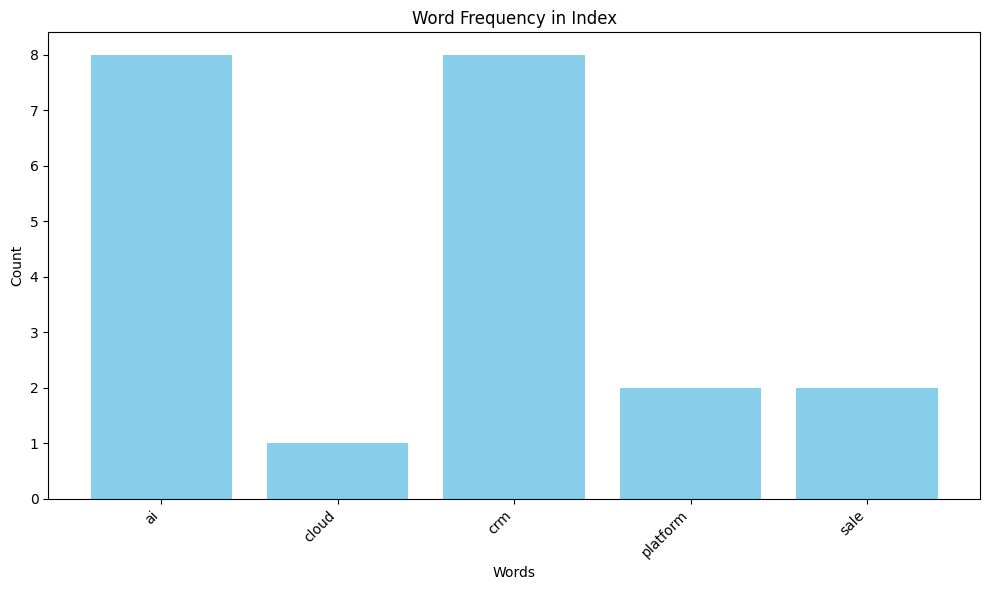

None


In [24]:
# TIRGUL 6 assignment - fetch each word from the index in firebase and show it's link and chart
import matplotlib.pyplot as plt
index_data = FBconn.get('/Index', None) #מביא דיקשינרי של כל המילים והקאונט שלהם

words = []
counts = []

for word, count in index_data.items(): #מציג עבור כל מילה את הקישור למיקום/רפרנס שלה באתר
    print(f"The Link for the word {word} is: https://www.salesforce.com/eu/agentforce/{word}/")
    print("\n")
    words.append(word)
    counts.append(count)


def show_chart(words, counts): #מציג גרף של כל מילה וכמה מופיעה
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')

    # Add labels and title
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title('Word Frequency in Index')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the chart
    plt.tight_layout()
    plt.show()


print(show_chart(words, counts))